In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchsummary import summary

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Hyperparameters

In [13]:
batch_size=64
learning_rate = 0.001
epochs = 30
# Optimizer: Adam

## Data

In [14]:
# 데이터 전처리 및 증강
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # AlexNet 입력 크기
    transforms.RandomHorizontalFlip(p=0.5),  # 랜덤으로 좌우 뒤집기
    transforms.RandomRotation(15),  # -15도에서 15도까지 랜덤 회전
    transforms.RandomCrop(224, padding=4),  # 패딩 후 랜덤 크롭
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 정규화
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # AlexNet 입력 크기
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 정규화
])

# CIFAR-10 데이터셋 로드
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)


train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [15]:
images, labels = next(iter(train_loader))
#224 X 224 RGB 이미지
images[0].shape

torch.Size([3, 224, 224])

### 학습 고정

In [16]:
def freeze_feature_extractor(model):
    for param in model.features.parameters():
        param.requires_grad = False  # Feature Extractor 고정

### Alexnet with skip connection

In [17]:
# Skip connection을 적용한 AlexNet 정의
class AlexNetWithSkip(nn.Module):
    def __init__(self):
        super(AlexNetWithSkip, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # 1x1 Convolution for channel matching
        self.match_channels = nn.Conv2d(64, 192, kernel_size=1, stride=1, padding=0)
        
        # Fully Connected Layers
        self.nonlinear = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256 * 6 * 6, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
        )
        self.linear_regressor = nn.Linear(128, 10)

        
    def forward(self, x):
        # Features forward with skip connection
        x1 = self.features[0:3](x)  # Initial layers
        x2 = self.features[3:6](x1)  # Second set of layers
        
        # Match channels of x1 to x2 using 1x1 Conv
        x1_matched = self.match_channels(x1)
        
        # Match spatial size of x1_matched to x2 using interpolation
        x1_resized = nn.functional.interpolate(x1_matched, size=x2.shape[2:], mode='bilinear', align_corners=False)
        
        # Skip connection: Add x1_resized to x2
        x2 = x2 + x1_resized
        
        x3 = self.features[6:](x2)  # Remaining layers
        x = x3.view(x3.size(0), 256 * 6 * 6)
        x = self.nonlinear(x)
        x = self.linear_regressor(x)
        return x

In [18]:
# 모델, 손실 함수, 옵티마이저 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_WithSkip = AlexNetWithSkip().to(device)
freeze_feature_extractor(model_WithSkip)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_WithSkip.parameters(), lr=learning_rate)

In [19]:
summary(model_WithSkip, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 192, 27, 27]          12,480
            Conv2d-8          [-1, 384, 13, 13]         663,936
              ReLU-9          [-1, 384, 13, 13]               0
           Conv2d-10          [-1, 256, 13, 13]         884,992
             ReLU-11          [-1, 256, 13, 13]               0
           Conv2d-12          [-1, 256, 13, 13]         590,080
             ReLU-13          [-1, 256, 13, 13]               0
        MaxPool2d-14            [-1, 25

Epoch 1/30, Train Loss: 0.0786, Train Acc: 35.15%, Val Loss: 0.0718, Val Acc: 43.35%
Epoch 2/30, Train Loss: 0.0716, Train Acc: 43.31%, Val Loss: 0.0669, Val Acc: 48.87%
Epoch 3/30, Train Loss: 0.0685, Train Acc: 47.22%, Val Loss: 0.0645, Val Acc: 52.70%
Epoch 4/30, Train Loss: 0.0670, Train Acc: 48.34%, Val Loss: 0.0622, Val Acc: 53.67%
Epoch 5/30, Train Loss: 0.0656, Train Acc: 50.07%, Val Loss: 0.0619, Val Acc: 54.27%
Epoch 6/30, Train Loss: 0.0647, Train Acc: 51.21%, Val Loss: 0.0598, Val Acc: 56.21%
Epoch 7/30, Train Loss: 0.0640, Train Acc: 52.02%, Val Loss: 0.0592, Val Acc: 57.43%
Epoch 8/30, Train Loss: 0.0631, Train Acc: 53.20%, Val Loss: 0.0595, Val Acc: 57.00%
Epoch 9/30, Train Loss: 0.0625, Train Acc: 53.70%, Val Loss: 0.0575, Val Acc: 59.39%
Epoch 10/30, Train Loss: 0.0621, Train Acc: 54.18%, Val Loss: 0.0568, Val Acc: 59.60%
Epoch 11/30, Train Loss: 0.0614, Train Acc: 54.78%, Val Loss: 0.0562, Val Acc: 60.26%
Epoch 12/30, Train Loss: 0.0609, Train Acc: 55.63%, Val Loss: 0

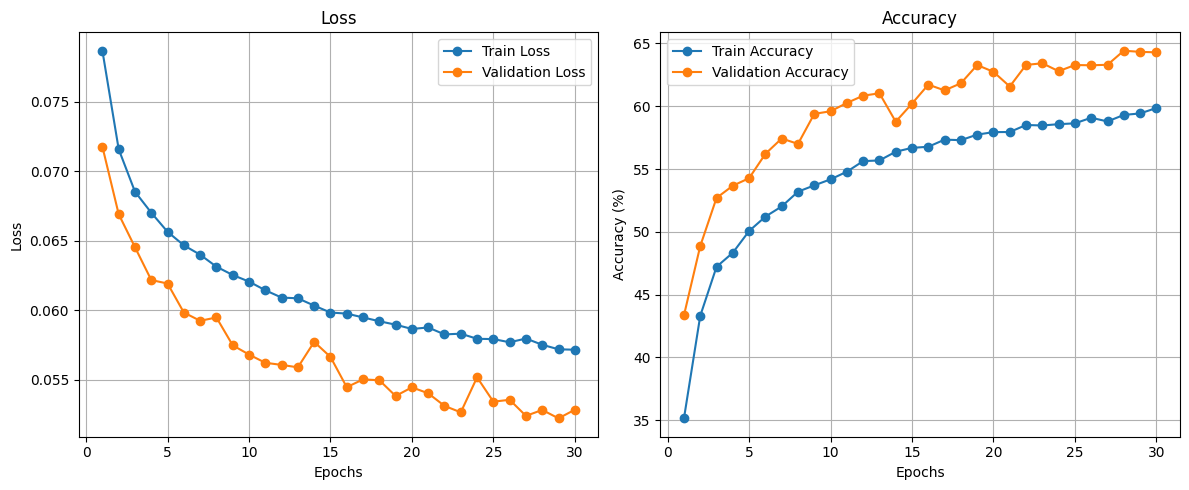

In [20]:
# 학습 및 검증 루프 추가
train_losses_with_skip = []
val_losses_with_skip = []
train_accuracies_WithSkip = []
val_accuracies_WithSkip = []

for epoch in range(epochs):
    # Training Phase
    model_WithSkip.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)

        optimizer.zero_grad()
        outputs = model_WithSkip(inputs)

        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)  # Top-1 prediction
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses_with_skip.append(train_loss)
    train_accuracies_WithSkip.append(train_accuracy)

    # Validation Phase
    model_WithSkip.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)

            outputs = model_WithSkip(inputs)
            loss = criterion(outputs, labels_one_hot)

            val_loss += loss.item()
            _, preds = outputs.max(1)  # Top-1 prediction
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val * 100
    val_losses_with_skip.append(val_loss)
    val_accuracies_WithSkip.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# 훈련 및 검증 결과 시각화
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses_with_skip, marker='o', label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses_with_skip, marker='o', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies_WithSkip, marker='o', label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies_WithSkip, marker='o', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Test Loss: 0.0520
Top-1 Accuracy: 64.96%
Top-3 Accuracy: 88.80%


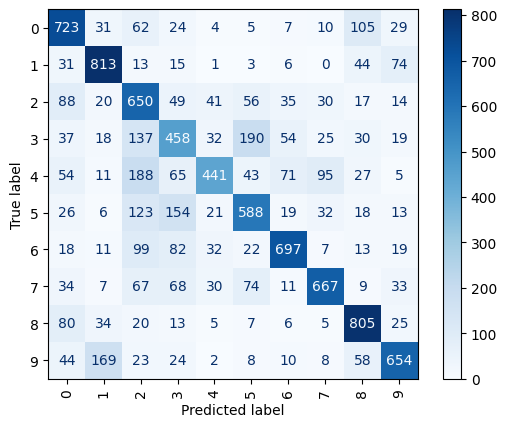

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model_WithSkip.eval()
test_loss_WithSkip = 0.0
correct_top1_WithSkip = 0
correct_top3_WithSkip = 0
total_WithSkip = 0
all_labels_WithSkip = []
all_preds_WithSkip = []
all_outputs_WithSkip = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 라벨을 one-hot 인코딩
        labels = labels.long()  # LongTensor로 변환
        labels_one_hot = F.one_hot(labels, num_classes=10).float()  # One-hot 인코딩 후 float 변환

        outputs = model_WithSkip(inputs)

        # 손실 계산
        loss = criterion(outputs, labels_one_hot)
        test_loss_WithSkip += loss.item()

        # Top-1 및 Top-3 정확도 계산
        _, top1_preds = outputs.topk(1, dim=1)  # Top-1 예측
        _, top3_preds = outputs.topk(3, dim=1)  # Top-3 예측

        correct_top1_WithSkip += (top1_preds.squeeze(1) == labels).sum().item()  # Top-1 맞춘 개수
        correct_top3_WithSkip += (labels.unsqueeze(1) == top3_preds).sum().item()  # Top-3 맞춘 개수
        total_WithSkip += labels.size(0)

        # Confusion Matrix를 위한 값 저장
        all_labels_WithSkip.extend(labels.cpu().numpy())
        all_preds_WithSkip.extend(top1_preds.squeeze(1).cpu().numpy())
        all_outputs_WithSkip.append(outputs.cpu().numpy())

# 평균 손실 및 정확도 계산
test_loss_WithSkip /= len(test_loader)
top1_accuracy = correct_top1_WithSkip / total_WithSkip * 100
top3_accuracy = correct_top3_WithSkip / total_WithSkip * 100

# Confusion Matrix 생성 및 표시
conf_matrix = confusion_matrix(all_labels_WithSkip, all_preds_WithSkip)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(10))
disp.plot(cmap='Blues', xticks_rotation='vertical')

print(f"Test Loss: {test_loss_WithSkip:.4f}")
print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-3 Accuracy: {top3_accuracy:.2f}%")

### alexnet with no skip connection

In [22]:
import torch
import torch.nn as nn

class AlexNetWithNoSkip(nn.Module):
    def __init__(self, output_dim=10):
        super(AlexNetWithNoSkip, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # Feature map 크기를 고정
        self.nonlinear = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 128),  # Flatten 후 비선형 계층
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )
        self.linear_regressor = nn.Linear(128, output_dim)  # 최종 선형 회귀 계층

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.nonlinear(x)
        x = self.linear_regressor(x)
        return x

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_WithNoSkip = AlexNetWithNoSkip(output_dim=10).to(device)
freeze_feature_extractor(model_WithNoSkip)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model_WithNoSkip.parameters(), lr=learning_rate)

In [24]:
summary(model_WithNoSkip, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
AdaptiveAvgPool2d-12            [-1, 256, 6, 6]               0
          Dropout-13                 [-1, 9216]               0
           Linear-14                  [

Epoch 1/30, Train Loss: 0.0853, Train Acc: 25.06%, Val Loss: 0.0801, Val Acc: 34.79%
Epoch 2/30, Train Loss: 0.0813, Train Acc: 30.46%, Val Loss: 0.0774, Val Acc: 37.26%
Epoch 3/30, Train Loss: 0.0800, Train Acc: 32.05%, Val Loss: 0.0768, Val Acc: 40.93%
Epoch 4/30, Train Loss: 0.0792, Train Acc: 33.30%, Val Loss: 0.0756, Val Acc: 40.13%
Epoch 5/30, Train Loss: 0.0785, Train Acc: 34.17%, Val Loss: 0.0742, Val Acc: 43.09%
Epoch 6/30, Train Loss: 0.0779, Train Acc: 34.95%, Val Loss: 0.0742, Val Acc: 43.49%
Epoch 7/30, Train Loss: 0.0776, Train Acc: 35.18%, Val Loss: 0.0725, Val Acc: 44.03%
Epoch 8/30, Train Loss: 0.0771, Train Acc: 35.86%, Val Loss: 0.0725, Val Acc: 45.93%
Epoch 9/30, Train Loss: 0.0771, Train Acc: 36.04%, Val Loss: 0.0729, Val Acc: 44.14%
Epoch 10/30, Train Loss: 0.0770, Train Acc: 36.04%, Val Loss: 0.0724, Val Acc: 46.26%
Epoch 11/30, Train Loss: 0.0766, Train Acc: 36.74%, Val Loss: 0.0716, Val Acc: 46.01%
Epoch 12/30, Train Loss: 0.0764, Train Acc: 37.07%, Val Loss: 0

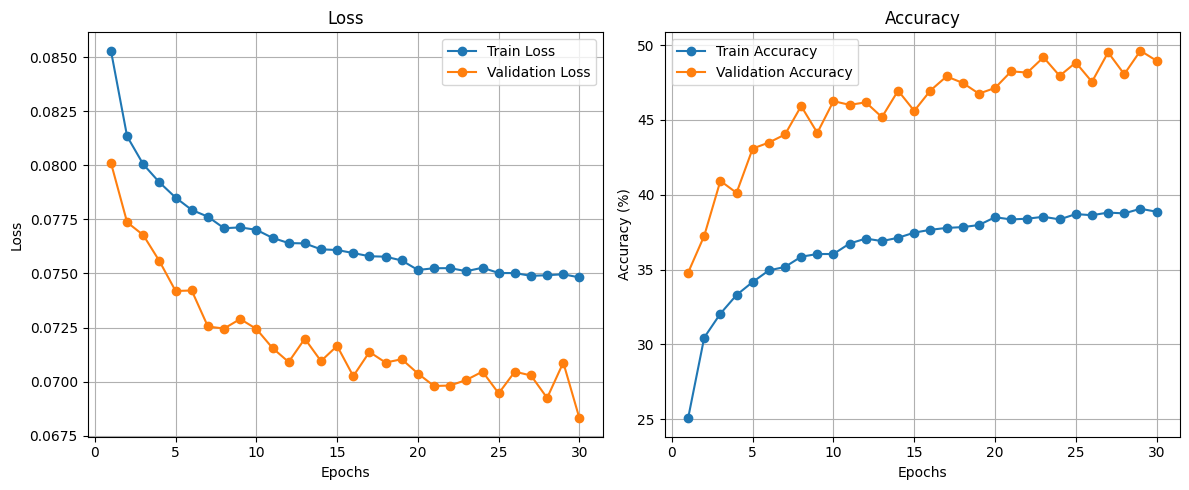

In [25]:
# 학습 및 검증 루프 추가
train_losses_with_Noskip = []
val_losses_with_Noskip = []
train_accuracies_WithNoSkip = []
val_accuracies_WithNoSkip = []

for epoch in range(epochs):
    # Training Phase
    model_WithNoSkip.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)

        optimizer.zero_grad()
        outputs = model_WithNoSkip(inputs)

        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)  # Top-1 prediction
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses_with_Noskip.append(train_loss)
    train_accuracies_WithNoSkip.append(train_accuracy)

    # Validation Phase
    model_WithNoSkip.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)

            outputs = model_WithNoSkip(inputs)
            loss = criterion(outputs, labels_one_hot)

            val_loss += loss.item()
            _, preds = outputs.max(1)  # Top-1 prediction
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val * 100
    val_losses_with_Noskip.append(val_loss)
    val_accuracies_WithNoSkip.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# 훈련 및 검증 결과 시각화
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses_with_Noskip, marker='o', label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses_with_Noskip, marker='o', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies_WithNoSkip, marker='o', label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies_WithNoSkip, marker='o', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Test Loss: 0.0673
Top-1 Accuracy: 49.80%
Top-3 Accuracy: 81.26%


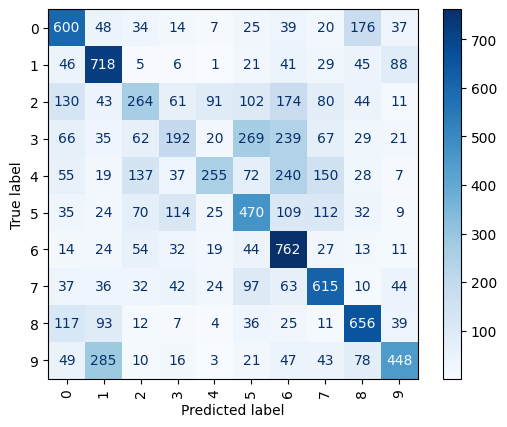

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model_WithNoSkip.eval()
test_loss_WithNoSkip = 0.0
correct_top1_WithNoSkip = 0
correct_top3_WithNoSkip = 0
total_WithNoSkip = 0
all_labels_WithNoSkip = []
all_preds_WithNoSkip = []
all_outputs_WithNoSkip = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 라벨을 one-hot 인코딩
        labels = labels.long()  # LongTensor로 변환
        labels_one_hot = F.one_hot(labels, num_classes=10).float()  # One-hot 인코딩 후 float 변환

        outputs = model_WithNoSkip(inputs)

        # 손실 계산
        loss = criterion(outputs, labels_one_hot)
        test_loss_WithNoSkip += loss.item()

        # Top-1 및 Top-3 정확도 계산
        _, top1_preds = outputs.topk(1, dim=1)  # Top-1 예측
        _, top3_preds = outputs.topk(3, dim=1)  # Top-3 예측

        correct_top1_WithNoSkip += (top1_preds.squeeze(1) == labels).sum().item()  # Top-1 맞춘 개수
        correct_top3_WithNoSkip += (labels.unsqueeze(1) == top3_preds).sum().item()  # Top-3 맞춘 개수
        total_WithNoSkip += labels.size(0)

        # Confusion Matrix를 위한 값 저장
        all_labels_WithNoSkip.extend(labels.cpu().numpy())
        all_preds_WithNoSkip.extend(top1_preds.squeeze(1).cpu().numpy())
        all_outputs_WithNoSkip.append(outputs.cpu().numpy())

# 평균 손실 및 정확도 계산
test_loss_WithNoSkip /= len(test_loader)
top1_accuracy = correct_top1_WithNoSkip / total_WithNoSkip * 100
top3_accuracy = correct_top3_WithNoSkip / total_WithNoSkip * 100

# Confusion Matrix 생성 및 표시
conf_matrix = confusion_matrix(all_labels_WithNoSkip, all_preds_WithNoSkip)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(10))
disp.plot(cmap='Blues', xticks_rotation='vertical')

print(f"Test Loss: {test_loss_WithNoSkip:.4f}")
print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-3 Accuracy: {top3_accuracy:.2f}%")


## PCA

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# PCA 직접 구현
def pca_manual(data, n_components=2):
    # 1. 데이터 평균 제거 (중심화)
    mean_data = np.mean(data, axis=0)
    centered_data = data - mean_data

    # 2. 공분산 행렬 계산
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # 3. 고유값 및 고유벡터 계산
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # 4. 고유값 기준으로 내림차순 정렬
    sorted_indices = np.argsort(eigenvalues)[::-1]  # 내림차순 정렬 인덱스
    eigenvectors = eigenvectors[:, sorted_indices]  # 정렬된 고유벡터
    eigenvalues = eigenvalues[sorted_indices]       # 정렬된 고유값

    # 5. 상위 n_components 선택
    selected_eigenvectors = eigenvectors[:, :n_components]

    # 6. 데이터 변환
    transformed_data = np.dot(centered_data, selected_eigenvectors)

    return transformed_data, eigenvalues, selected_eigenvectors


In [ ]:
def explained_variance(eigenvalues, n_components):
    total_variance = np.sum(eigenvalues)
    explained_ratios = eigenvalues / total_variance
    cumulative_explained_ratios = np.cumsum(explained_ratios)
    return explained_ratios[:n_components], cumulative_explained_ratios[:n_components]

1) skip connection

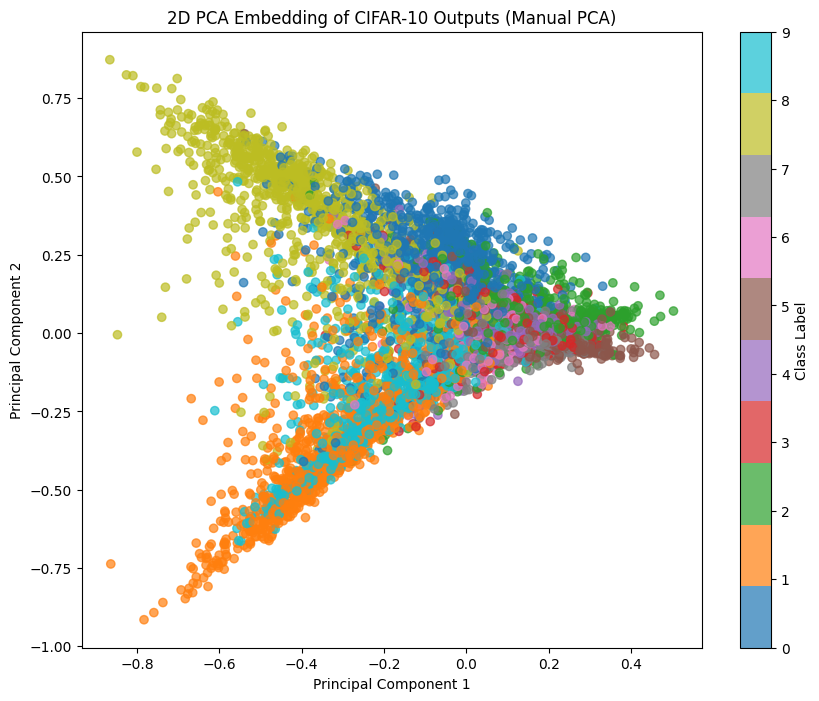

Eigenvalues of covariance matrix: [5.52724798e-02 4.71979344e-02 3.44065344e-02 2.77562464e-02
 2.43628744e-02 2.24856806e-02 2.09699239e-02 9.69342925e-03
 4.86051433e-03 1.46696092e-06]


In [44]:
# PCA 시각화
# 모델 출력값을 하나의 배열로 병합
all_outputs_WithSkip = np.concatenate(all_outputs_WithSkip, axis=0)  # [num_samples, 10]

# PCA 직접 구현 적용
outputs_pca, eigenvalues, eigenvectors = pca_manual(all_outputs_WithSkip, n_components=2)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    outputs_pca[:, 0], outputs_pca[:, 1], c=all_labels_WithSkip, cmap='tab10', alpha=0.7
)
plt.colorbar(scatter, label="Class Label")
plt.title("2D PCA Embedding of CIFAR-10 Outputs (Manual PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 고유값 출력
print("Eigenvalues of covariance matrix:", eigenvalues)

In [ ]:
n_components = 2
explained_ratios, cumulative_ratios = explained_variance(eigenvalues, n_components)

print("Explained Variance Ratios:", explained_ratios)
print("Cumulative Explained Variance Ratios:", cumulative_ratios)

2) NO skip connection 

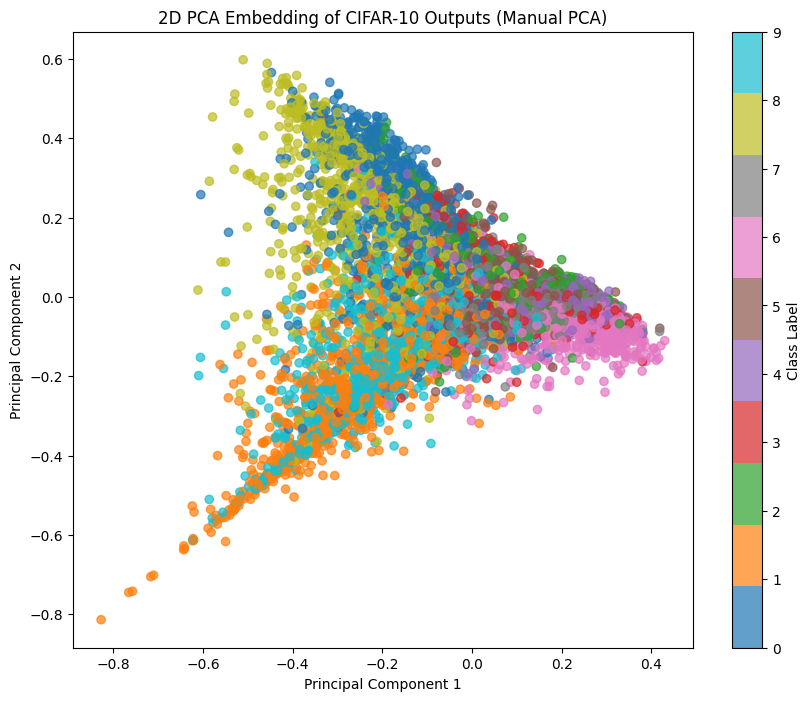

Eigenvalues of covariance matrix: [4.06216796e-02 2.69853344e-02 1.90972967e-02 1.14244672e-02
 9.26494362e-03 6.14609383e-03 4.88608539e-03 9.20537234e-04
 4.11661121e-04 4.88607681e-07]


In [34]:
# 모델 출력값을 하나의 배열로 병합
all_outputs_WithNoSkip = np.concatenate(all_outputs_WithNoSkip, axis=0)  # [num_samples, 10]

# PCA 직접 구현 적용
outputs_pca, eigenvalues, eigenvectors = pca_manual(all_outputs_WithNoSkip, n_components=2)

# PCA 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    outputs_pca[:, 0], outputs_pca[:, 1], c=all_labels_WithNoSkip, cmap='tab10', alpha=0.7
)
plt.colorbar(scatter, label="Class Label")
plt.title("2D PCA Embedding of CIFAR-10 Outputs (Manual PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 고유값 출력
print("Eigenvalues of covariance matrix:", eigenvalues)

In [ ]:
n_components = 2
explained_ratios, cumulative_ratios = explained_variance(eigenvalues, n_components)

print("Explained Variance Ratios:", explained_ratios)
print("Cumulative Explained Variance Ratios:", cumulative_ratios)